In [4]:
import pandas as pd
import numpy as np
import scipy
import chaospy
import seaborn as sns
import sklearn
import keras
import plotnine
import altair
import matplotlib.pyplot as plt

This notebook implements the persistence model and univariate RNN for forecasting 6 time steps ahead average power production from wind turbines. 

Author: Aeishwarya Baviskar


# Univariate Model 

# Data import

In [5]:
df_all = pd.read_csv('.\data\DataScienceCourse_EDPdata.csv', delimiter=';')

In [6]:
Turbine_IDs = np.unique(df_all.Turbine_ID.values)
print(df_all.columns)

Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg',
       'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg',
       'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
       'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Prod_LatestAvg_ReactPwrGen2', 'Prod_LatestAvg_TotReactPwr',
       'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg',
       'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Gen_SlipRing_Temp_Avg', 'Spin

### The Wind farm comprises of the following 5 turbines
- T01
- T06
- T07
- T09
- T11

For the Univariate model we are only concerned with the power output from the Wind Turbines. Hence we only have time and the power output as variables. 

However, there are points where the turbines are in idling or transient mode. These points needs to be eliminated before we go forward with the persistence model.

The variables of interest for modeling are

#### To predict 6 time steps ahead / hour ahead
- Grd_Prod_Pwr_Avg


For analysis of the data: {Generator RPM and Wind Speed}

- Gen_RPM_Avg
- Amb_WindSpeed_Avg


# Task 1: Sorting the data and dividing it in different tables per turbine

In [7]:
Turbine_IDs

array(['T01', 'T06', 'T07', 'T09', 'T11'], dtype=object)

In [8]:
num_of_turbines = len(Turbine_IDs) # this gets repititive 

In [9]:
turbines_dict = {}
for i in range(num_of_turbines): 
    FilterMask = (df_all.Turbine_ID == Turbine_IDs[i])
    temp = pd.DataFrame([df_all.Amb_WindSpeed_Avg[FilterMask], df_all.Status_Flag[FilterMask],\
                         df_all.Gen_RPM_Min[FilterMask], df_all.Gen_RPM_Max[FilterMask], \
                         df_all.Grd_Prod_Pwr_Std[FilterMask], df_all.Grd_Prod_Pwr_Max[FilterMask],  
                          df_all.Grd_Prod_Pwr_Avg[FilterMask], df_all.Grd_Prod_Pwr_Min[FilterMask],
                          df_all.Timestamp[FilterMask] ]).transpose().sort_values('Timestamp').reset_index(drop = True)
    temp.Timestamp = pd.to_datetime(temp.Timestamp.values)
    temp.set_index('Timestamp', inplace=True)
    turbines_dict[Turbine_IDs[i]] = temp 


##### Subtask: to find how much of the data is missing. 

# Here we analyze the data to find outliers

In [10]:
TurbineOK = turbines_dict['T01'].Status_Flag==0
TurbineTransient = turbines_dict['T01'].Status_Flag == 1
TurbineIdling = turbines_dict['T01'].Status_Flag == 2

In [11]:
# count how many timestamps are available: 
count_of_data = df_all.groupby('Turbine_ID').count()

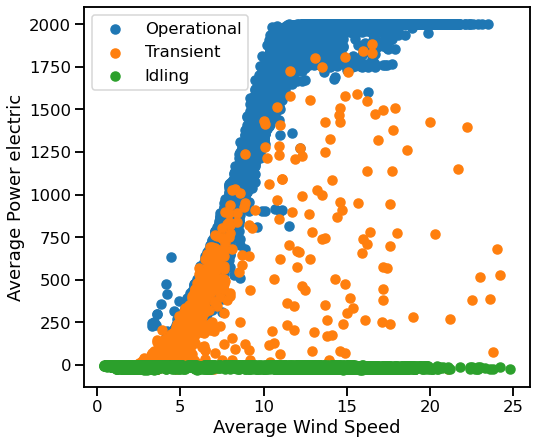

In [15]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,7))
plt.scatter(turbines_dict['T01'].Amb_WindSpeed_Avg[TurbineOK],turbines_dict['T01'][TurbineOK].Grd_Prod_Pwr_Avg, label='Operational' )
plt.scatter(turbines_dict['T01'].Amb_WindSpeed_Avg[TurbineTransient],turbines_dict['T01'][TurbineTransient].Grd_Prod_Pwr_Avg, label='Transient' )
plt.scatter(turbines_dict['T01'].Amb_WindSpeed_Avg[TurbineIdling],turbines_dict['T01'][TurbineIdling].Grd_Prod_Pwr_Avg ,  label='Idling' )
plt.legend(loc=2)
plt.xlabel('Average Wind Speed')
plt.ylabel('Average Power electric')
plt.show()

In [16]:
# Calculate number of missing data steps
for i in range(num_of_turbines): 
    print(f'start index: {turbines_dict[Turbine_IDs[i]].index[0]} End index: {turbines_dict[Turbine_IDs[i]].index[-1]}')
    missing_time_stamps = pd.date_range(start=turbines_dict[Turbine_IDs[i]].index[0],
                                    end=turbines_dict[Turbine_IDs[i]].index[-1], 
                                    freq='10min').difference(turbines_dict[Turbine_IDs[i]].index)
    print(f'Number of missing timesteps in {Turbine_IDs[i]}: {len(missing_time_stamps)}')

start index: 2016-01-01 00:00:00+00:00 End index: 2017-09-01 00:00:00+00:00
Number of missing timesteps in T01: 557
start index: 2016-01-01 00:00:00+00:00 End index: 2017-09-01 00:00:00+00:00
Number of missing timesteps in T06: 2315
start index: 2016-01-01 00:00:00+00:00 End index: 2017-09-01 00:00:00+00:00
Number of missing timesteps in T07: 496
start index: 2016-01-01 00:00:00+00:00 End index: 2017-09-01 00:00:00+00:00
Number of missing timesteps in T09: 547
start index: 2016-01-01 00:00:00+00:00 End index: 2017-09-01 00:00:00+00:00
Number of missing timesteps in T11: 455


We will use the starting time index of the last turbine and check how many time stamps are missing

In [17]:
for i in range(num_of_turbines): 
    #print(f'start index: {turbines_dict[Turbine_IDs[i]].index[0]} End index: {turbines_dict[Turbine_IDs[i]].index[-1]}')
    missing_time_stamps = pd.date_range(start=turbines_dict[Turbine_IDs[-1]].index[0],
                                    end=turbines_dict[Turbine_IDs[i]].index[-1], 
                                    freq='10min').difference(turbines_dict[Turbine_IDs[i]].index)
    print(f'Number of missing timesteps in {Turbine_IDs[i]}: {len(missing_time_stamps)}')

Number of missing timesteps in T01: 557
Number of missing timesteps in T06: 2315
Number of missing timesteps in T07: 496
Number of missing timesteps in T09: 547
Number of missing timesteps in T11: 455


In [18]:
# print how many Nan values exist: 
for i in range(num_of_turbines):
    print(f'Number of NaN values for {Turbine_IDs[i]}:\n{ turbines_dict[Turbine_IDs[i]].isna().sum()}\n')

Number of NaN values for T01:
Amb_WindSpeed_Avg    0
Status_Flag          0
Gen_RPM_Min          0
Gen_RPM_Max          0
Grd_Prod_Pwr_Std     0
Grd_Prod_Pwr_Max     0
Grd_Prod_Pwr_Avg     0
Grd_Prod_Pwr_Min     0
dtype: int64

Number of NaN values for T06:
Amb_WindSpeed_Avg    0
Status_Flag          0
Gen_RPM_Min          0
Gen_RPM_Max          0
Grd_Prod_Pwr_Std     0
Grd_Prod_Pwr_Max     0
Grd_Prod_Pwr_Avg     0
Grd_Prod_Pwr_Min     0
dtype: int64

Number of NaN values for T07:
Amb_WindSpeed_Avg    0
Status_Flag          0
Gen_RPM_Min          0
Gen_RPM_Max          0
Grd_Prod_Pwr_Std     0
Grd_Prod_Pwr_Max     0
Grd_Prod_Pwr_Avg     0
Grd_Prod_Pwr_Min     0
dtype: int64

Number of NaN values for T09:
Amb_WindSpeed_Avg    0
Status_Flag          0
Gen_RPM_Min          0
Gen_RPM_Max          0
Grd_Prod_Pwr_Std     0
Grd_Prod_Pwr_Max     0
Grd_Prod_Pwr_Avg     0
Grd_Prod_Pwr_Min     0
dtype: int64

Number of NaN values for T11:
Amb_WindSpeed_Avg    0
Status_Flag          0
Gen_RPM_Min 

There are no NaN values in the data, only missing timesteps
### Next step will be to resample the data and place NaN values in place

In [19]:
sampling_rate = '10min'
for i in Turbine_IDs:
    # first we remove duplicate timestamps
    turbines_dict[i]  = turbines_dict[i][~turbines_dict[i].index.duplicated(keep='first')]
    # then resample the data and fill missing timestamps with NaN
    turbines_dict[i] = turbines_dict[i].resample(sampling_rate).asfreq()
    # check number of nans just to be sure_ 
    temp = turbines_dict[i].isna().sum()
    print(f'No of NaN values for turbine {i}:\n{temp}')

No of NaN values for turbine T01:
Amb_WindSpeed_Avg    557
Status_Flag          557
Gen_RPM_Min          557
Gen_RPM_Max          557
Grd_Prod_Pwr_Std     557
Grd_Prod_Pwr_Max     557
Grd_Prod_Pwr_Avg     557
Grd_Prod_Pwr_Min     557
dtype: int64
No of NaN values for turbine T06:
Amb_WindSpeed_Avg    2315
Status_Flag          2315
Gen_RPM_Min          2315
Gen_RPM_Max          2315
Grd_Prod_Pwr_Std     2315
Grd_Prod_Pwr_Max     2315
Grd_Prod_Pwr_Avg     2315
Grd_Prod_Pwr_Min     2315
dtype: int64
No of NaN values for turbine T07:
Amb_WindSpeed_Avg    496
Status_Flag          496
Gen_RPM_Min          496
Gen_RPM_Max          496
Grd_Prod_Pwr_Std     496
Grd_Prod_Pwr_Max     496
Grd_Prod_Pwr_Avg     496
Grd_Prod_Pwr_Min     496
dtype: int64
No of NaN values for turbine T09:
Amb_WindSpeed_Avg    547
Status_Flag          547
Gen_RPM_Min          547
Gen_RPM_Max          547
Grd_Prod_Pwr_Std     547
Grd_Prod_Pwr_Max     547
Grd_Prod_Pwr_Avg     547
Grd_Prod_Pwr_Min     547
dtype: int64
No o

# Persistence model implementation

#### We now define the persistence model:

The start index is 2016-01-01 00:00:00+00:00 so ignore the first 5 steps 

and start forecast after an hour 2016-01-01 01:00:00+00:00 

with the last observed value at 2016-01-01 00:50:00+00:00

In [20]:
def persistence_model(grd_power):
    grd_power_predict= [None]*grd_power.index.shape[0]
    grd_power_predict = np.array(grd_power_predict)
    # since we will skip the first 6 index for predictions, we substitute as is. 
    grd_power_predict[0:6] = grd_power.values[0:6]
    index_for_minute_50 = [i for i in range(len(grd_power.index)) if grd_power.index[i].minute==50]
    
    index_for_minute_60  =[i + 1 for i in index_for_minute_50]
    
    grd_power_predict[index_for_minute_60] = grd_power.values[index_for_minute_50]
    pedict_df = pd.DataFrame(grd_power_predict, index = grd_power.index, columns={'predict'}).ffill()
    return pedict_df

# 1. Backward fill

In [21]:
for i in Turbine_IDs: 
    turbines_dict[i].bfill(inplace=True)

In [23]:
turbine_predictions  = {}
# We add all the individual wind turbine avg powers to get the WF power
turbines_dict['WF'] = turbines_dict['T01'].Grd_Prod_Pwr_Avg + turbines_dict['T06'].Grd_Prod_Pwr_Avg +\
                      turbines_dict['T09'].Grd_Prod_Pwr_Avg + turbines_dict['T11'].Grd_Prod_Pwr_Avg + \
                      turbines_dict['T07'].Grd_Prod_Pwr_Avg
# Persistence model on individual turbines (defined earlier)
for i in Turbine_IDs: 
    turbine_predictions[i] = persistence_model(turbines_dict[i].Grd_Prod_Pwr_Avg)

In [24]:
# persistence model on the Wind Farm
turbine_predictions['WF'] = persistence_model(turbines_dict['WF'])

###  Persistence model on WF level


In [28]:
turbine_predictions['WF_added'] = turbine_predictions['T01']+ turbine_predictions['T06']+turbine_predictions['T07']+turbine_predictions['T09']+turbine_predictions['T11']

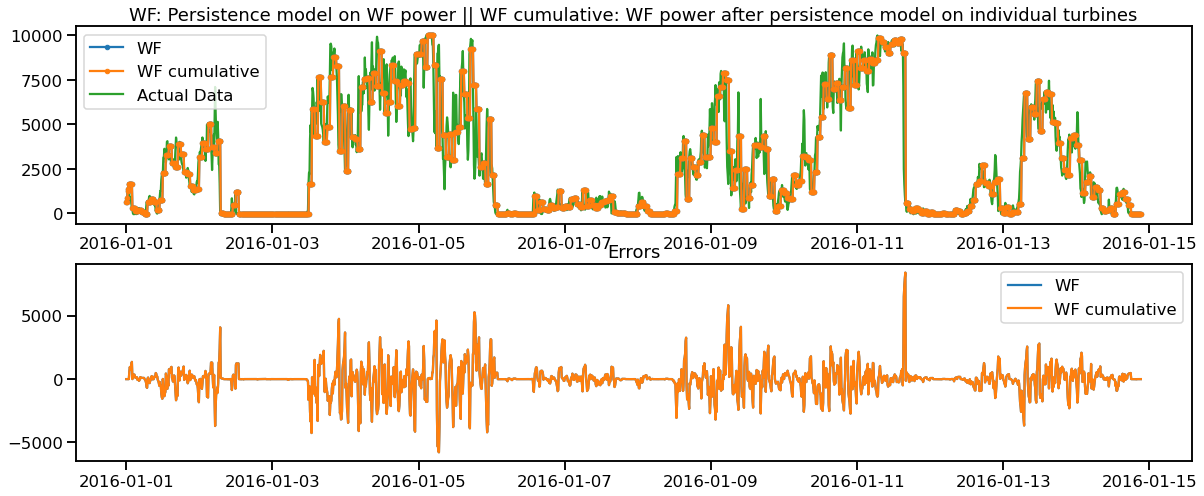

In [32]:
to_plot = 2000
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax1, ax2 = ax.flatten()
ax1.plot(turbine_predictions['WF'].index[:to_plot], turbine_predictions['WF'].predict[:to_plot], marker='.', label='WF', zorder=1)

ax1.plot(turbine_predictions['WF_added'].index[:to_plot], turbine_predictions['WF_added'].predict[:to_plot], marker='.', label='WF cumulative', zorder=3)
ax1.plot(turbines_dict['WF'].index[:to_plot], turbines_dict['WF'].values[:to_plot], label='Actual Data', zorder=0)
ax1.set_title('WF: Persistence model on WF power || WF cumulative: WF power after persistence model on individual turbines')
ax1.legend()
ax2.plot(turbines_dict['WF'].index[:to_plot], turbine_predictions['WF'].predict[:to_plot]-turbines_dict['WF'].values[:to_plot],  label='WF')
ax2.plot(turbines_dict['WF'].index[:to_plot], turbine_predictions['WF'].predict[:to_plot]-turbines_dict['WF'].values[:to_plot], label='WF cumulative')
ax2.set_title('Errors')
ax2.legend()
plt.show()

# There is no difference observed between both the WF and WF cumulative power

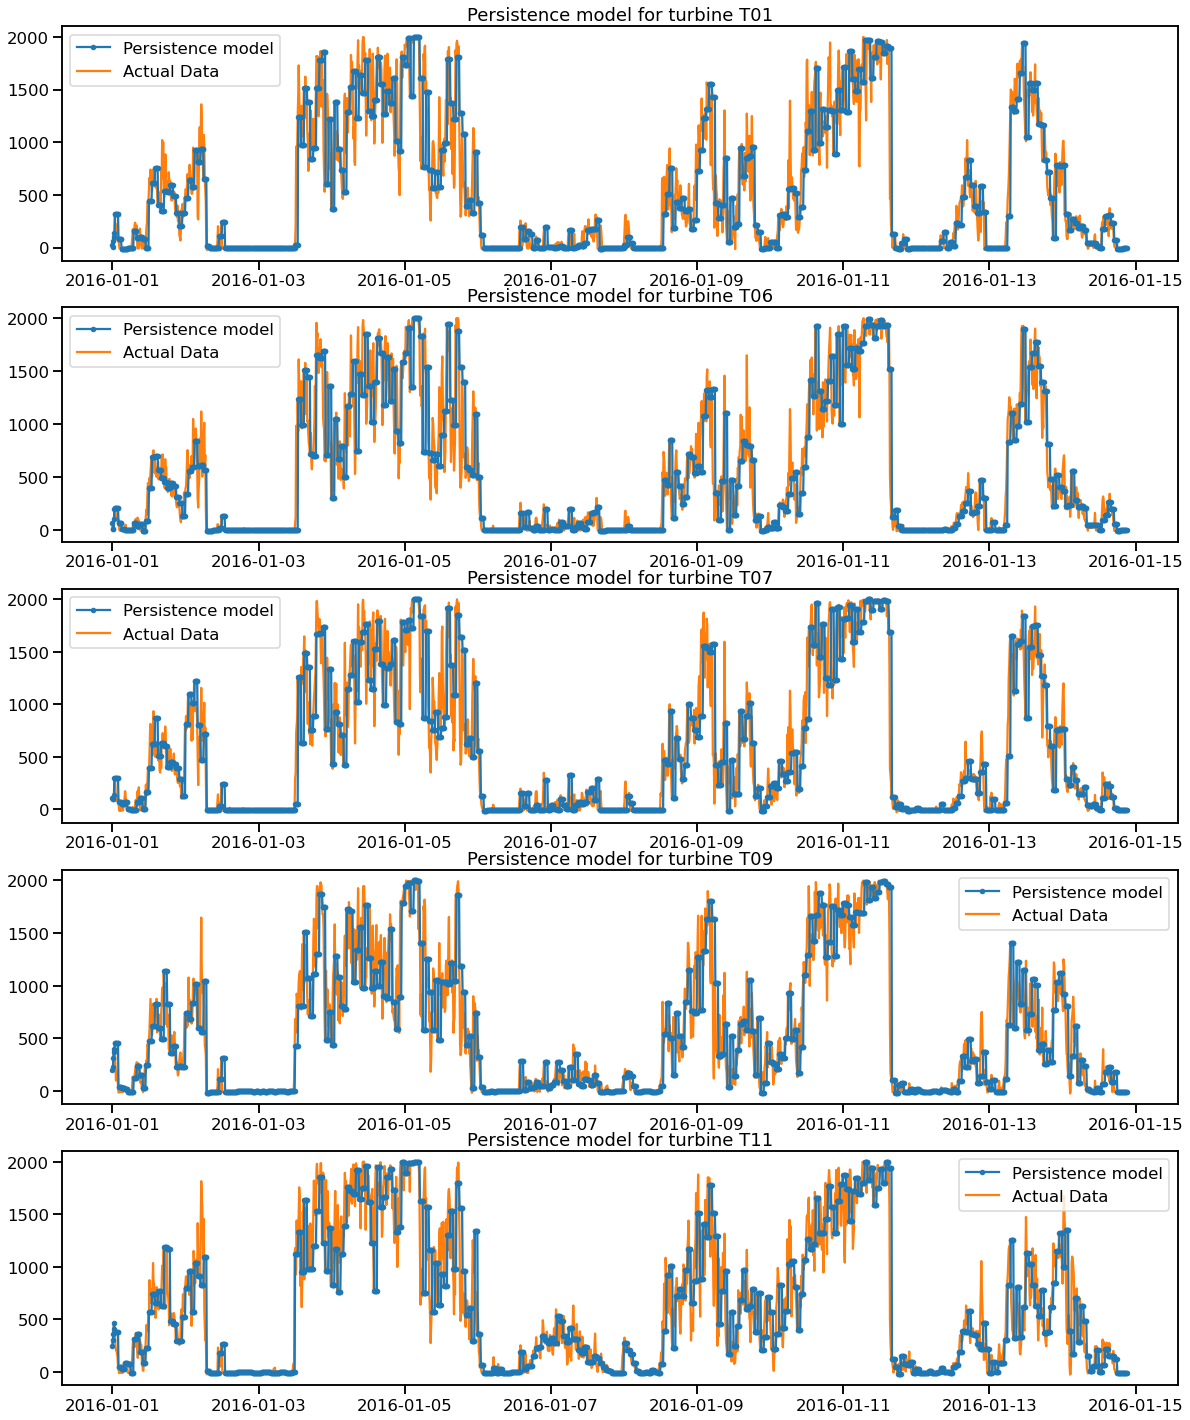

In [26]:
to_plot = 2000
sns.set_context('talk')
fig, ax = plt.subplots(len(Turbine_IDs),1, figsize=(20,25))
#ax1, ax2 = ax.flatten()
k = 0
for turbine in Turbine_IDs:
    ax[k].plot(turbine_predictions[turbine].index[:to_plot], turbine_predictions[turbine].predict[:to_plot], marker='.', label='Persistence model', zorder=1)
    ax[k].plot(turbines_dict[turbine].index[:to_plot], turbines_dict[turbine].Grd_Prod_Pwr_Avg[:to_plot], label='Actual Data', zorder=0)
    ax[k].set_title(f'Persistence model for turbine {turbine}')
    ax[k].legend()
    k = k+1
#ax2.plot(turbines_dict['WF'].index[:to_plot], turbine_predictions['WF'].predict[:to_plot]-turbines_dict['WF'].values[:to_plot])
#ax2.set_title('Errors')
plt.show()

In [36]:
for i in Turbine_IDs:
    RMSE = np.sqrt(sum((turbine_predictions[i].predict.values-turbines_dict[i].Grd_Prod_Pwr_Avg)**2))/len(turbine_predictions[i].predict.values)
    print(f"RMSE error {i}: {RMSE}")
i = 'WF'
RMSE = np.sqrt(sum((turbine_predictions[i].predict.values-turbines_dict[i].values)**2))/len(turbine_predictions[i].predict.values)
print(f"RMSE error for {i}: {RMSE}")
i = 'WF_added'
RMSE = np.sqrt(sum((turbine_predictions[i].predict.values-turbines_dict['WF'].values)**2))/len(turbine_predictions[i].predict.values)
print(f"RMSE error for {i}: {RMSE}")

RMSE error T01: 0.8991887801294041
RMSE error T06: 0.8353988394496599
RMSE error T07: 0.932402410695476
RMSE error T09: 0.891190361291871
RMSE error T11: 0.8777260907291778
RMSE error for WF: 3.423985249855392
RMSE error for WF_added: 3.423985249855392


# The aim is to do better than the persistence model with univariate Neural network forecasting model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout

### Since the model is univariate we use LSTM which is a recursive neural network with 5 layers

The following function is only the Neural network definition. 

In [38]:
def design_model(X):
  model = Sequential()

  # Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], 1)))
  model.add(Dropout(0.2))

  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))

  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))

  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))

  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

### Preprocess X: 
Since we are predicting one hour ahead, X which is the input matrix will have the following form

        x(t) | x(t+1) | x(t+2) | x(t+3) | x(t+4)| x(t+5)  -> y = x(t+6)
        ...............................................................
        x(t+1) | x(t+2) | x(t+3) | x(t+4)| x(t+5) | x(t+6) -> y = x(t+7)


### Split data into training (60%), test(20%) and validation sets (20%)

In [46]:
def divide_data(dataset, name):
    # preparing X and Y 
    # the output is one hour ahead predictions. So we shift the average power back by 6 time steps to get the hour ahead predictions
    Y = dataset[name].Grd_Prod_Pwr_Avg.shift(-6)
    Y.dropna(inplace=True) # drop NANs in the end
    Y = Y.values.reshape(-1, 1) # numpy array

    X = np.zeros([len(Y),6])
    # Prepare X
    for i in range(6):
        temp = dataset[name].Grd_Prod_Pwr_Avg.shift(-i)
        temp.dropna(inplace=True)
        X[:,i] = temp.values[:len(Y)]
    #X = turbines_dict['T01'].Grd_Prod_Pwr_Avg.values[:len(Y)].reshape(-1, 1) # make x same length as Y 
    # The first part is demonstration over only Turbine 01
    #dataset = turbines_dict['T01']


    train_int = np.int(0.6*len(Y)) # 60% of the data length for training
    validation_int = np.int(0.8*len(Y)) # 20% more for validation

    # training input vector
    X_train = X[:train_int]

    # training output vector
    Y_train = Y[:train_int]        

    # validation input vector
    X_validation = X[train_int:validation_int]

    # validation output vector
    Y_validation = Y[train_int:validation_int]

    # test input vector
    X_test = X[validation_int:]

    # test output vector
    Y_test = Y[validation_int:]
    
    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test

### Scale given training and validation data and make the model design

In [47]:
def scale_X_make_LSTM_model(X_train, Y_train, X_validation): 
    scaler_X = MinMaxScaler(feature_range=(0,1)) # Scaling X
    X_train_scaled = scaler_X.fit_transform(X_train) 
    X_validation_scaled = scaler_X.transform(X_validation)
    X_test_scaled = scaler_X.transform(X_test)
    K.clear_session() 
    # Input reshape for LSTM
    no_features = 1
    n_lag = 6
    # Reshaping X for LSTM
    train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features))
    validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, no_features))
    test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, no_features))
    # making model 
    model = design_model(train_X)
    
    return model, train_X, validation_X,  test_X, scaler_X

In [100]:
history = {}
model = {}
validation_X = {}
validation_Y= {}
Y_test = {}
test_X = {}
scaler_Y = {}

## In the following step we iterate through all the turbines while fitting the neural network. 

All necessary data is stored in respective dictionaries defined in the previous step. 

##### NOTE: This step takes almost 2 hours. 

In [135]:
for turbine in Turbine_IDs:
    X_train, Y_train, X_validation, Y_validation, X_test, Y_test[turbine] = divide_data(turbines_dict, turbine)
    model[turbine], train_X, validation_X[turbine],  test_X[turbine], scaler_X =  scale_X_make_LSTM_model(X_train, Y_train, X_validation)
    scaler_Y[turbine] = MinMaxScaler(feature_range=(0,1))
    train_Y = scaler_Y[turbine].fit_transform(Y_train)
    validation_Y[turbine] = scaler_Y[turbine].transform(Y_validation)
    Y_test[turbine] = scaler_Y[turbine].transform(Y_test[turbine])
    history[turbine] = model[turbine].fit(train_X, train_Y, epochs = 20, batch_size = 32, verbose=1,
         validation_data=(validation_X[turbine], validation_Y[turbine]))
    

Train on 52614 samples, validate on 17538 samples
Epoch 1/20
52614/52614 [==============================] - 32s 616us/sample - loss: 0.0135 - val_loss: 0.0070
Epoch 2/20
52614/52614 [==============================] - 27s 506us/sample - loss: 0.0072 - val_loss: 0.0060
Epoch 3/20
52614/52614 [==============================] - 27s 508us/sample - loss: 0.0069 - val_loss: 0.0061
Epoch 4/20
52614/52614 [==============================] - 26s 500us/sample - loss: 0.0067 - val_loss: 0.0056
Epoch 5/20
52614/52614 [==============================] - 26s 500us/sample - loss: 0.0067 - val_loss: 0.0062
Epoch 6/20
52614/52614 [==============================] - 27s 511us/sample - loss: 0.0066 - val_loss: 0.0058
Epoch 7/20
52614/52614 [==============================] - 28s 535us/sample - loss: 0.0066 - val_loss: 0.0055
Epoch 8/20
52614/52614 [==============================] - 30s 564us/sample - loss: 0.0065 - val_loss: 0.0059
Epoch 9/20
52614/52614 [==============================] - 30s 568us/sample - l

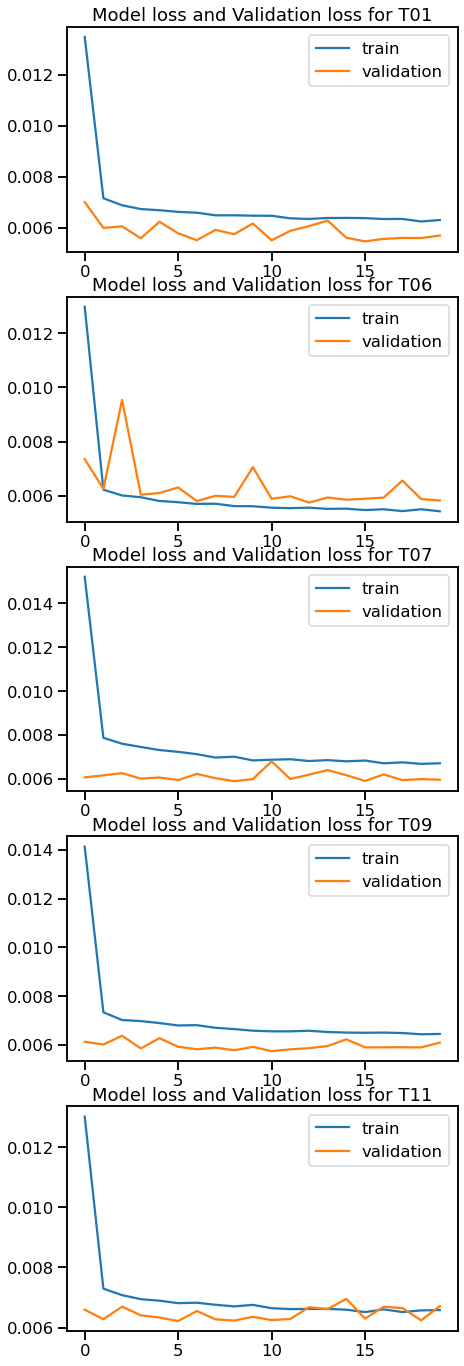

In [136]:
# Plot model error vs validation error
sns.set_context('talk')
fig, ax = plt.subplots(len(Turbine_IDs), figsize=(7,24))
k = 0
for turbine in Turbine_IDs:
    ax[k].plot(history[turbine].history['loss'], label='train')
    ax[k].plot(history[turbine].history['val_loss'], label='validation')
    ax[k].set_title(f"Model loss and Validation loss for {turbine}")
    ax[k].legend()
    k = k+1
    
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
#plt.legend()
plt.show()



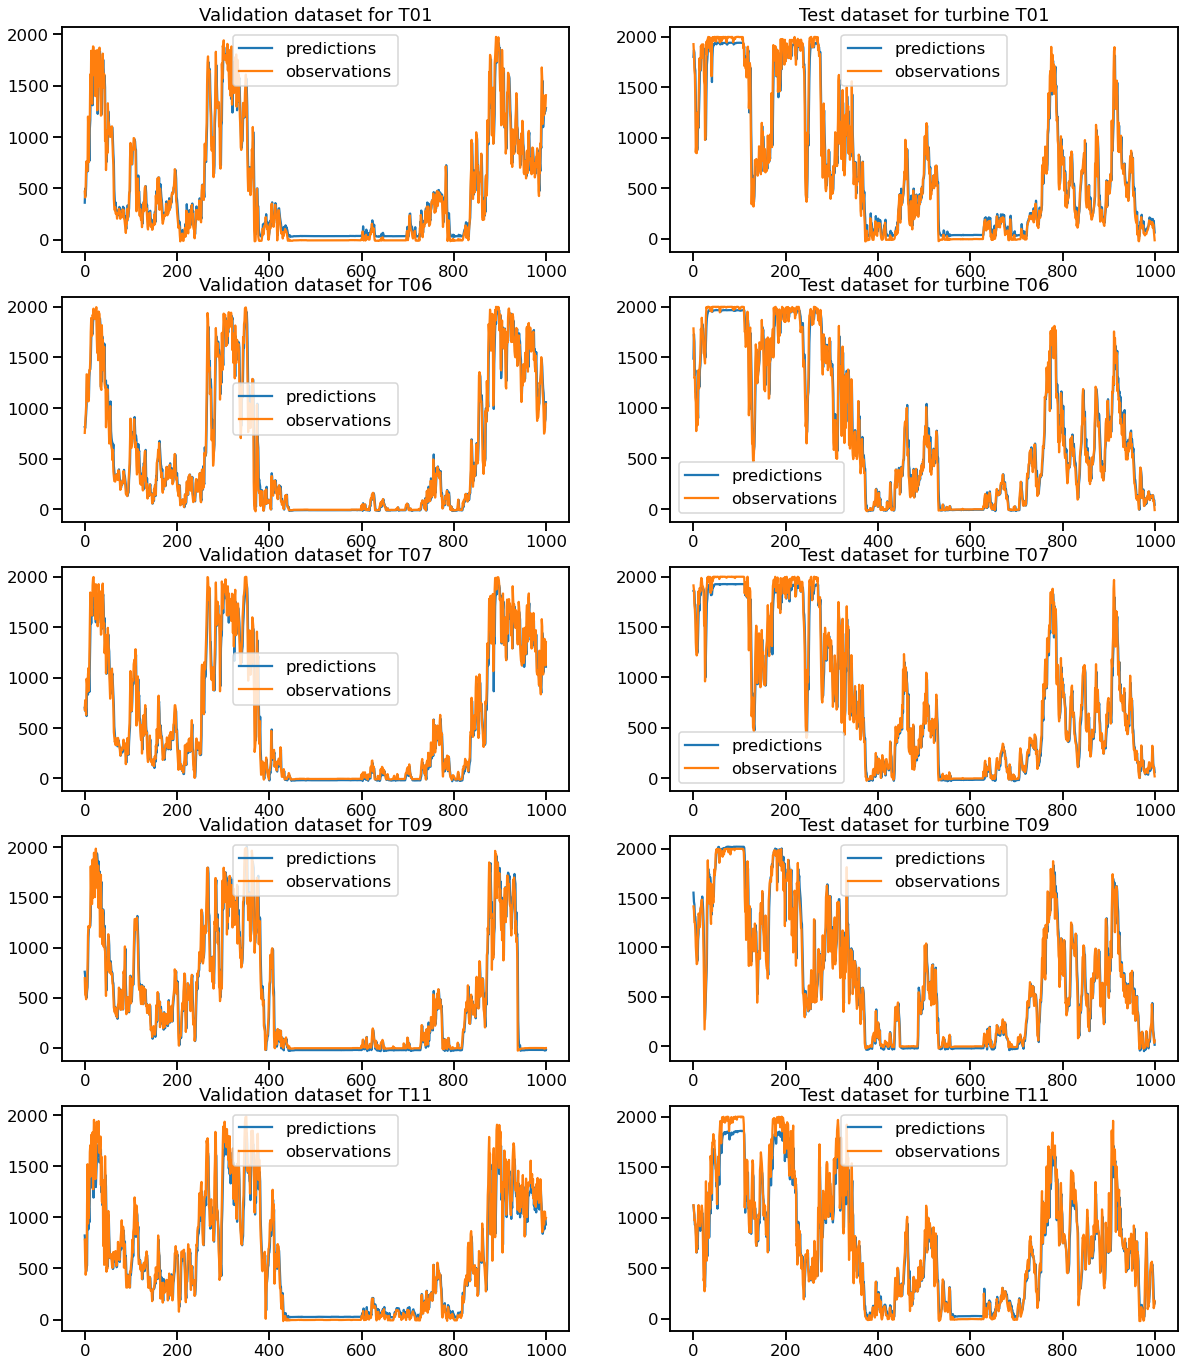

In [137]:
# Let's check the predictions
# calculate predictions for validation dataset
#pred_val_unscaled = model.predict(X_validation_scaled)
#pd.DataFrame(pred_val_unscaled).plot()
sns.set_context('talk')
fig, ax = plt.subplots(len(Turbine_IDs),2, figsize=(20,24))
k = 0
no_points = 1000
for turbine in Turbine_IDs:
    pred_val = scaler_Y[turbine].inverse_transform(model[turbine].predict(validation_X[turbine]))
    ax[k,0].plot(pred_val[:no_points], label = 'predictions')
    ax[k,0].plot(scaler_Y[turbine].inverse_transform(validation_Y[turbine][:no_points]), label = 'observations') 
    ax[k,0].legend()
    ax[k,0].set_title(f'Validation dataset for {turbine}')

    # calculate predictions for test dataset
    pred_test = scaler_Y[turbine].inverse_transform(model[turbine].predict(test_X[turbine]))

    ax[k,1].plot(pred_test[:no_points], label = 'predictions')
    ax[k,1].plot(scaler_Y[turbine].inverse_transform(Y_test[turbine][:no_points]), label = 'observations') 
    ax[k,1].legend()
    ax[k,1].set_title(f'Test dataset for turbine {turbine}')
    k = k+1
plt.show()

In [142]:
for turbine in Turbine_IDs:
    model_loss = history[turbine].history['loss'][-1]
    validation_loss = history[turbine].history['val_loss'][-1]
    print(f"For Turbine {turbine}\n model loss:{model_loss} || Validation loss:{validation_loss} ")

For Turbine T01
 model loss:0.006308033037362524 || Validation loss:0.005698410172301336 
For Turbine T06
 model loss:0.005425750534159028 || Validation loss:0.00582389216731321 
For Turbine T07
 model loss:0.006706099443508093 || Validation loss:0.005954646134317539 
For Turbine T09
 model loss:0.006441000070339764 || Validation loss:0.0060838253515116065 
For Turbine T11
 model loss:0.006582379331035895 || Validation loss:0.006711842324257607 


# In comparison to the persistence model, univariate RNN performs better